# 데이터 로드

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
train = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\train.csv')
test = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\test.csv')
submission = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\gender_submission.csv')

In [62]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [63]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [64]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [65]:
train.shape, test.shape

((891, 12), (418, 11))

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [67]:
print('train 데이터의 columns :', list(train.columns))
print('test 데이터의 columns', list(test.columns))

train 데이터의 columns : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
test 데이터의 columns ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [68]:
# null값 확인
print('Check null value of train')
print(train.isnull().sum())
print('='*30)
print('Check null value of test')
print(test.isnull().sum())

Check null value of train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Check null value of test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [69]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

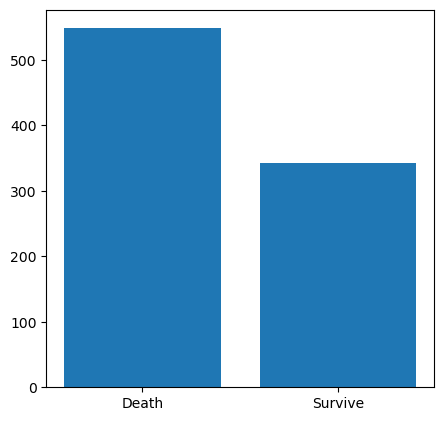

In [70]:
# label의 분포 확인
plt.figure(figsize = (5,5), dpi = 100)
plt.bar(['Death','Survive'], train['Survived'].value_counts().sort_index())
plt.show()

In [71]:
feature = list(train.columns)
train_x = train.drop(['Survived'], axis = 1)
train_y = train['Survived'].values

### 각 피쳐값에 대한 설명
#### Survived : 생존여부(1이면 생존, 0이면 사망)
#### pclass : ticket class, 1= 1st(upper), 2 = 2nd(middle), 3 = 3rd(lower)
#### name : 이름, sex : 성별, age : 나이
#### Sibsp : 함께 탑승한 형제/배우자의 수
#### Parch : 함께 탑승한 부모/자식의 수. 아이들 중 오직 보모만 존재할 경우 0값
#### Ticket : 티켓 넘버
#### Fare : 승객요금
#### Cabin : 객실번호
#### Embarked : 승선항(탑승장소)

# 전처리

In [72]:
train_x

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [73]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [74]:
# train set 전처리

train_x['Sex'] = train_x['Sex'].map({'male':0, 'female':1}) # 남자는 0, 여자는 1로 맵핑

train_x['FamilySize'] = train_x['SibSp'] + train_x['Parch'] # 동행자수를 합한 새로운 피쳐 생성
train_x['IsAlone'] = 0
for i in range(0, len(train_x)):
    if train_x['FamilySize'][i] > 0:
        train_x['IsAlone'][i] = 0
    else:
        train_x['IsAlone'][i] = 1

for i in range(0, len(train_x)):
    if train_x['Name'][i].find('Mr.') != -1:
        train_x['Name'][i] = 0
    elif train_x['Name'][i].find('Mrs.') != -1:
        train_x['Name'][i] = 3
    elif train_x['Name'][i].find('Miss.') != -1:
        train_x['Name'][i] = 2
    elif train_x['Name'][i].find('Ms.') != -1:
        train_x['Name'][i] = 2
    else:
        train_x['Name'][i] = 1

#train_x['Cabin'] = train_x['Cabin'].str[:1] # 객실 등급을 의미하는 첫번째 알파벳만 추출
#train_x['Cabin'] = train_x['Cabin'].fillna('null') # 결측값을 모두 null이라는 문자로 변환
#encoder.fit(train_x['Cabin'])
#train_x['Cabin'] = encoder.transform(train_x['Cabin']) # Cabin 값 라벨 인코딩

train_x['Embarked'] = train_x['Embarked'].map({'S':0, 'C':2, 'Q':1}) # 생존률에 따라 수를 맵핑

train_x = train_x.drop(['PassengerId', 'Ticket', 'SibSp', 'Parch', 'Cabin'], axis = 1) # 필요 없는 피쳐 삭제

C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel imp

In [75]:
# test set 전처리

test['Sex'] = test['Sex'].map({'male':0, 'female':1}) # 남자는 0, 여자는 1로 맵핑

test['FamilySize'] = test['SibSp'] + test['Parch'] # 동행자수를 합한 새로운 피쳐 생성
test['IsAlone'] = 0 # 혼자 탑승한 경우
for i in range(0, len(test)):
    if test['FamilySize'][i] > 0:
        test['IsAlone'][i] = 0
    else:
        test['IsAlone'][i] = 1

for i in range(0, len(test)):
    if test['Name'][i].find('Mr.') != -1:
        test['Name'][i] = 0
    elif test['Name'][i].find('Mrs.') != -1:
        test['Name'][i] = 3
    elif test['Name'][i].find('Miss.') != -1:
        test['Name'][i] = 2
    elif test['Name'][i].find('Ms.') != -1:
        test['Name'][i] = 2
    else:
        test['Name'][i] = 1

#test['Cabin'] = test['Cabin'].str[:1] # 객실 등급을 의미하는 첫번째 알파벳만 추출
#test['Cabin'] = test['Cabin'].fillna('null')
#test['Cabin'] = encoder.transform(test['Cabin']) # Cabin 값 라벨 인코딩

test['Embarked'] = test['Embarked'].map({'S':0, 'C':2, 'Q':1}) # 생존률에 따라 수를 맵핑

test = test.drop(['PassengerId', 'Ticket', 'SibSp', 'Parch', 'Cabin'], axis = 1) # 필요 없는 피쳐 삭제

C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\sjm\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel imp

# 결측값

In [76]:
print(train_x.isnull().sum())
print('='*20)
print(test.isnull().sum())

Pclass          0
Name            0
Sex             0
Age           177
Fare            0
Embarked        2
FamilySize      0
IsAlone         0
dtype: int64
Pclass         0
Name           0
Sex            0
Age           86
Fare           1
Embarked       0
FamilySize     0
IsAlone        0
dtype: int64


In [77]:
train_x['Embarked'].value_counts()

0.0    644
2.0    168
1.0     77
Name: Embarked, dtype: int64

In [78]:
# EMbarked 피쳐의 경우 결측값이 2개 밖에 없으므로 크게 신경쓰지 않아도 된다.
# 최빈값 정도로 채워주는 것이 적당하다.
# Embarked의 경우 0이 최빈값
train_x['Embarked'] = train_x['Embarked'].fillna(0)

In [79]:
# test set의 fare피쳐의 경우 결측값이 1개 밖에 없다.
# 무시해도 좋은 수준이기 때문에 train set의 median으로 대체해 준다.
test['Fare'] = test['Fare'].fillna(train_x['Fare'].median())

In [80]:
grouped_by_name = train_x['Age'].groupby(train_x['Name'])
grouped_by_name.mean()

Name
0    32.368090
1    20.306066
2    21.816327
3    35.898148
Name: Age, dtype: float64

In [81]:
# 이름의 호칭을 나타내는 값으로 결측값을 예측한다.

train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 0),'Age']  = 32
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 1),'Age']  = 20
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 2),'Age']  = 21
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 3),'Age']  = 35

test.loc[ (test['Age'].isnull()) & (test['Name'] == 0),'Age']  = 32
test.loc[ (test['Age'].isnull()) & (test['Name'] == 1),'Age']  = 20
test.loc[ (test['Age'].isnull()) & (test['Name'] == 2),'Age']  = 21
test.loc[ (test['Age'].isnull()) & (test['Name'] == 3),'Age']  = 35

In [82]:
train_x = train_x.drop(['Name'], axis = 1) # 필요 없는 피쳐 삭제
test = test.drop(['Name'], axis = 1) # 필요 없는 피쳐 삭제

In [83]:
train_x.isnull().sum()

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
dtype: int64

# 원핫인코딩

In [25]:
#train_pclass_onehot = pd.get_dummies(train_x['Pclass'], drop_first = False)
train_Embarked_onehot = pd.get_dummies(train_x['Embarked'], drop_first = False)

#test_pclass_onehot = pd.get_dummies(test['Pclass'], drop_first = False)
test_Embarked_onehot = pd.get_dummies(test['Embarked'], drop_first = False)

In [27]:
train_x = pd.concat([train_x, train_Embarked_onehot], axis = 1)
train_x = train_x.drop(['Embarked'], axis = 1) 

test = pd.concat([test, test_Embarked_onehot], axis = 1)
test = test.drop(['Embarked'], axis = 1) 

# 바이닝

In [155]:
# Age binning

train_x['Age_binning'] = 0
train_x.loc[train_x['Age'] <= 8, 'Age_binning'] = 0
train_x.loc[(train_x['Age'] > 8) & (train_x['Age'] <= 16), 'Age_binning'] = 1
train_x.loc[(train_x['Age'] > 16) & (train_x['Age'] <= 24), 'Age_binning'] = 2
train_x.loc[(train_x['Age'] > 24) & (train_x['Age'] <= 32), 'Age_binning'] = 3
train_x.loc[(train_x['Age'] > 32) & (train_x['Age'] <= 40), 'Age_binning'] = 4
train_x.loc[(train_x['Age'] > 40) & (train_x['Age'] <= 48), 'Age_binning'] = 5
train_x.loc[(train_x['Age'] > 48) & (train_x['Age'] <= 56), 'Age_binning'] = 6
train_x.loc[train_x['Age'] > 56, 'Age_binning'] = 7

test['Age_binning'] = 0
test.loc[test['Age'] <= 8, 'Age_binning'] = 0
test.loc[(test['Age'] > 8) & (test['Age'] <= 16), 'Age_binning'] = 1
test.loc[(test['Age'] > 16) & (test['Age'] <= 24), 'Age_binning'] = 2
test.loc[(test['Age'] > 24) & (test['Age'] <= 32), 'Age_binning'] = 3
test.loc[(test['Age'] > 32) & (test['Age'] <= 40), 'Age_binning'] = 4
test.loc[(test['Age'] > 40) & (test['Age'] <= 48), 'Age_binning'] = 5
test.loc[(test['Age'] > 48) & (test['Age'] <= 56), 'Age_binning'] = 6
test.loc[test['Age'] > 56, 'Age_binning'] = 7

In [335]:
# Fare binning

train_x['Fare_binning'] = 0
train_x.loc[train_x['Fare'] < 8, 'Fare_binning'] = 0
train_x.loc[(train_x['Fare'] >= 8) & (train_x['Fare'] < 16), 'Fare_binning'] = 1
train_x.loc[(train_x['Fare'] >= 16) & (train_x['Fare'] < 24), 'Fare_binning'] = 2
train_x.loc[(train_x['Fare'] >= 24) & (train_x['Fare'] < 32), 'Fare_binning'] = 3

train_x.loc[(train_x['Fare'] >= 32) & (train_x['Fare'] < 40), 'Fare_binning'] = 4
train_x.loc[(train_x['Fare'] >= 40) & (train_x['Fare'] < 48), 'Fare_binning'] = 5
train_x.loc[(train_x['Fare'] >= 48) & (train_x['Fare'] < 56), 'Fare_binning'] = 6
train_x.loc[train_x['Fare'] >= 56, 'Fare_binning'] = 7

test['Fare_binning'] = 0
test.loc[test['Fare'] < 8, 'Fare_binning'] = 0
test.loc[(test['Fare'] >= 8) & (test['Fare'] < 16), 'Fare_binning'] = 1
test.loc[(test['Fare'] >= 16) & (test['Fare'] < 24), 'Fare_binning'] = 2
test.loc[(test['Fare'] >= 24) & (test['Fare'] < 32), 'Fare_binning'] = 3

test.loc[(test['Fare'] >= 32) & (test['Fare'] < 40), 'Fare_binning'] = 4
test.loc[(test['Fare'] >= 40) & (test['Fare'] < 48), 'Fare_binning'] = 5
test.loc[(test['Fare'] >= 48) & (test['Fare'] < 56), 'Fare_binning'] = 6
test.loc[test['Fare'] >= 56, 'Fare_binning'] = 7

In [336]:
train_x = train_x.drop(['Age', 'Fare'], axis = 1) # 필요 없는 피쳐 삭제
test = test.drop(['Age', 'Fare'], axis = 1) # 필요 없는 피쳐 삭제

# 상관계수

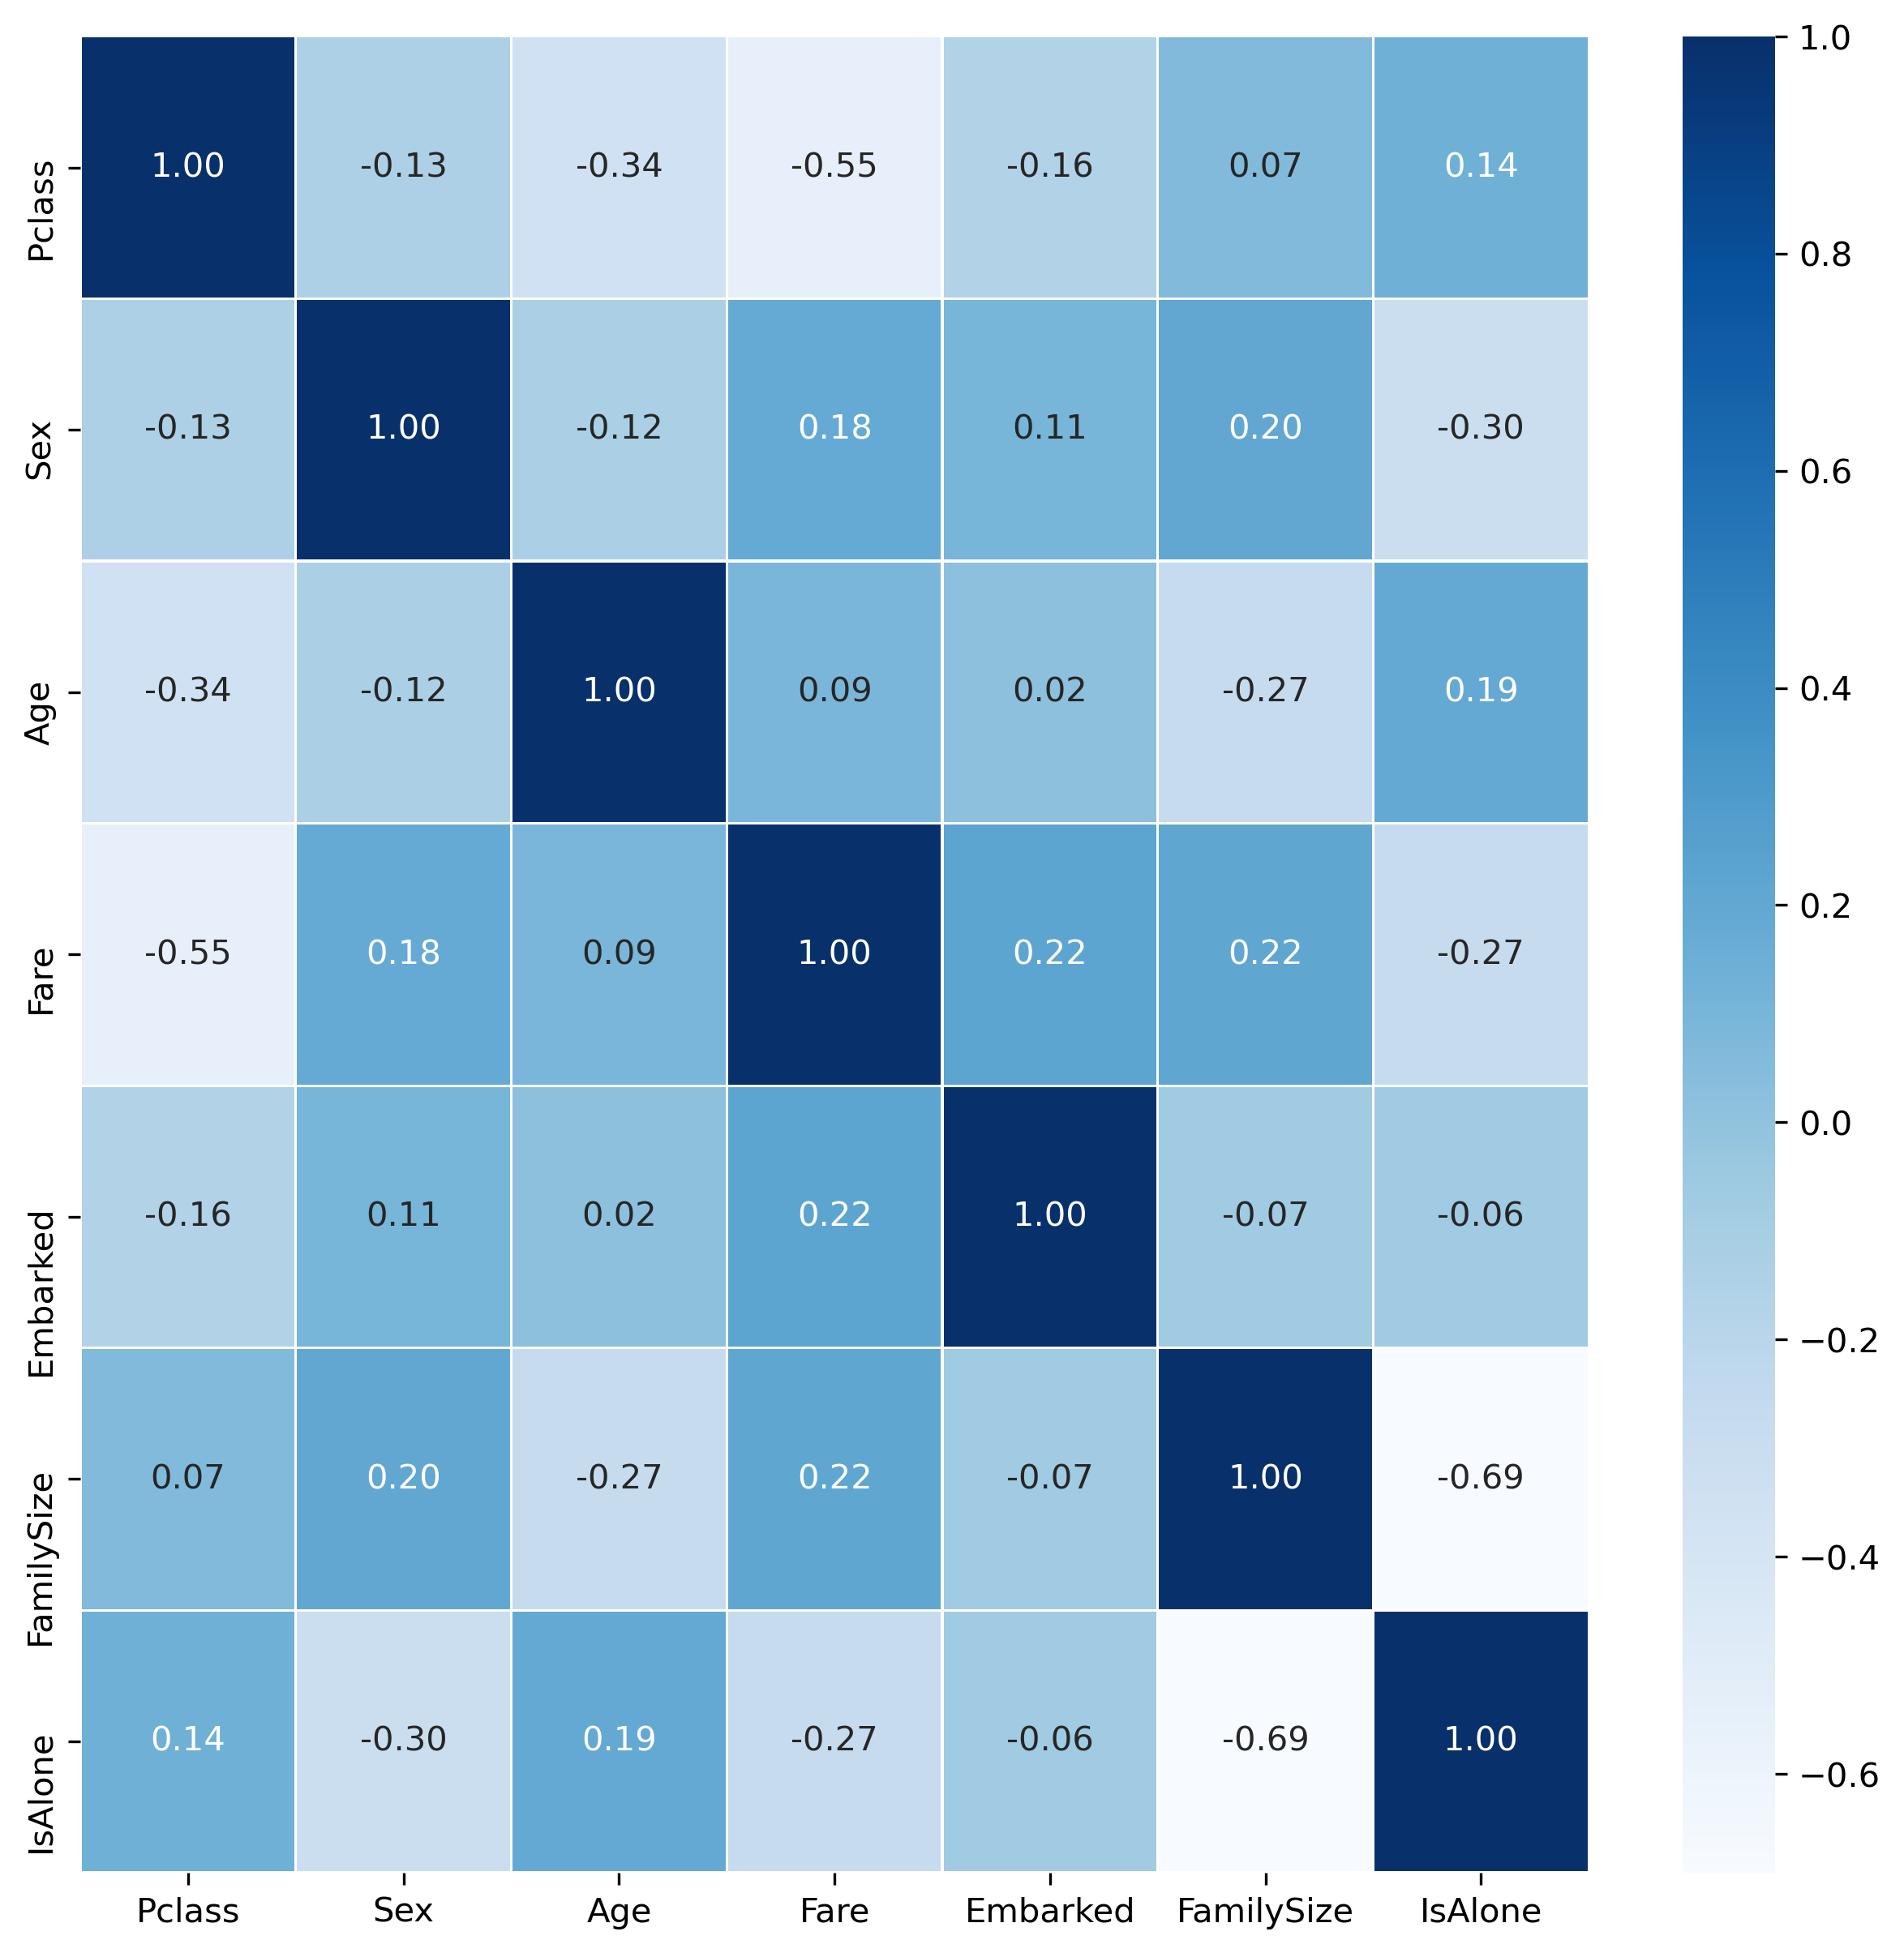

In [25]:
plt.figure(figsize=(10,10), dpi = 300)
sns.heatmap(train_x.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()

# 정규화

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test = scaler.transform(test)

# 특징값의 중요도

In [84]:
from catboost import CatBoostClassifier # CatBoost

cat_clf = CatBoostClassifier()
cat_clf.fit(train_x, train_y)

Learning rate set to 0.009807
0:	learn: 0.6872386	total: 257ms	remaining: 4m 16s
1:	learn: 0.6801872	total: 258ms	remaining: 2m 8s
2:	learn: 0.6744432	total: 259ms	remaining: 1m 26s
3:	learn: 0.6681231	total: 260ms	remaining: 1m 4s
4:	learn: 0.6647400	total: 261ms	remaining: 51.9s
5:	learn: 0.6594792	total: 262ms	remaining: 43.3s
6:	learn: 0.6533350	total: 263ms	remaining: 37.3s
7:	learn: 0.6486334	total: 264ms	remaining: 32.7s
8:	learn: 0.6423144	total: 265ms	remaining: 29.2s
9:	learn: 0.6368976	total: 266ms	remaining: 26.4s
10:	learn: 0.6319249	total: 268ms	remaining: 24.1s
11:	learn: 0.6262837	total: 269ms	remaining: 22.2s
12:	learn: 0.6217202	total: 270ms	remaining: 20.5s
13:	learn: 0.6170547	total: 271ms	remaining: 19.1s
14:	learn: 0.6118176	total: 273ms	remaining: 17.9s
15:	learn: 0.6072757	total: 274ms	remaining: 16.8s
16:	learn: 0.6022408	total: 275ms	remaining: 15.9s
17:	learn: 0.5977326	total: 276ms	remaining: 15.1s
18:	learn: 0.5929371	total: 278ms	remaining: 14.3s
19:	learn

295:	learn: 0.3557171	total: 608ms	remaining: 1.45s
296:	learn: 0.3556206	total: 610ms	remaining: 1.44s
297:	learn: 0.3553201	total: 611ms	remaining: 1.44s
298:	learn: 0.3552339	total: 612ms	remaining: 1.43s
299:	learn: 0.3549481	total: 613ms	remaining: 1.43s
300:	learn: 0.3547781	total: 614ms	remaining: 1.43s
301:	learn: 0.3545437	total: 616ms	remaining: 1.42s
302:	learn: 0.3543230	total: 617ms	remaining: 1.42s
303:	learn: 0.3540881	total: 618ms	remaining: 1.42s
304:	learn: 0.3539793	total: 619ms	remaining: 1.41s
305:	learn: 0.3538694	total: 620ms	remaining: 1.41s
306:	learn: 0.3537547	total: 622ms	remaining: 1.4s
307:	learn: 0.3537487	total: 622ms	remaining: 1.4s
308:	learn: 0.3536431	total: 623ms	remaining: 1.39s
309:	learn: 0.3535003	total: 625ms	remaining: 1.39s
310:	learn: 0.3534714	total: 626ms	remaining: 1.39s
311:	learn: 0.3533835	total: 627ms	remaining: 1.38s
312:	learn: 0.3531016	total: 628ms	remaining: 1.38s
313:	learn: 0.3529142	total: 630ms	remaining: 1.38s
314:	learn: 0.

580:	learn: 0.3209419	total: 948ms	remaining: 683ms
581:	learn: 0.3208271	total: 949ms	remaining: 681ms
582:	learn: 0.3206879	total: 950ms	remaining: 680ms
583:	learn: 0.3204340	total: 951ms	remaining: 678ms
584:	learn: 0.3203923	total: 953ms	remaining: 676ms
585:	learn: 0.3202025	total: 954ms	remaining: 674ms
586:	learn: 0.3201222	total: 955ms	remaining: 672ms
587:	learn: 0.3199858	total: 956ms	remaining: 670ms
588:	learn: 0.3199297	total: 957ms	remaining: 668ms
589:	learn: 0.3198011	total: 959ms	remaining: 666ms
590:	learn: 0.3197586	total: 960ms	remaining: 664ms
591:	learn: 0.3196524	total: 961ms	remaining: 662ms
592:	learn: 0.3195468	total: 962ms	remaining: 660ms
593:	learn: 0.3195323	total: 963ms	remaining: 658ms
594:	learn: 0.3194323	total: 964ms	remaining: 656ms
595:	learn: 0.3192856	total: 966ms	remaining: 655ms
596:	learn: 0.3191654	total: 967ms	remaining: 653ms
597:	learn: 0.3190083	total: 968ms	remaining: 651ms
598:	learn: 0.3189376	total: 969ms	remaining: 649ms
599:	learn: 

886:	learn: 0.2919749	total: 1.3s	remaining: 166ms
887:	learn: 0.2919233	total: 1.3s	remaining: 164ms
888:	learn: 0.2918164	total: 1.3s	remaining: 163ms
889:	learn: 0.2917019	total: 1.31s	remaining: 161ms
890:	learn: 0.2916430	total: 1.31s	remaining: 160ms
891:	learn: 0.2915247	total: 1.31s	remaining: 158ms
892:	learn: 0.2913456	total: 1.31s	remaining: 157ms
893:	learn: 0.2912749	total: 1.31s	remaining: 155ms
894:	learn: 0.2912207	total: 1.31s	remaining: 154ms
895:	learn: 0.2911863	total: 1.31s	remaining: 153ms
896:	learn: 0.2911421	total: 1.31s	remaining: 151ms
897:	learn: 0.2909519	total: 1.32s	remaining: 150ms
898:	learn: 0.2908545	total: 1.32s	remaining: 148ms
899:	learn: 0.2906568	total: 1.32s	remaining: 147ms
900:	learn: 0.2906222	total: 1.32s	remaining: 145ms
901:	learn: 0.2905347	total: 1.32s	remaining: 144ms
902:	learn: 0.2904252	total: 1.32s	remaining: 142ms
903:	learn: 0.2903332	total: 1.32s	remaining: 141ms
904:	learn: 0.2901270	total: 1.32s	remaining: 139ms
905:	learn: 0.2

In [85]:
# feature importance
cat_clf.feature_importances_

array([15.41603604, 35.33949119, 18.10993078, 16.21033188,  5.89152166,
        7.64641527,  1.38627318])

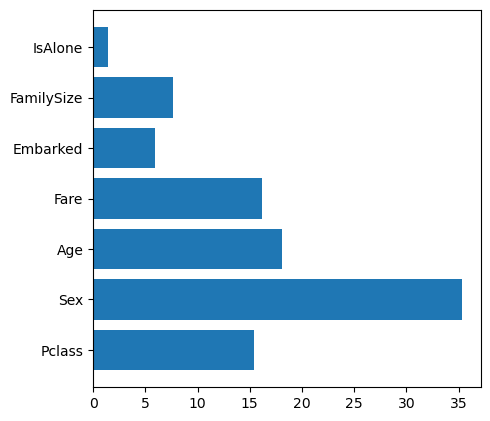

In [87]:
plt.figure(figsize = (5,5), dpi = 100)
plt.barh(train_x.columns, cat_clf.feature_importances_)
plt.show()

# 특징 선택

In [88]:
train_x

,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,7.2500,0.0,1,0
1,1,1,38.0,71.2833,2.0,1,0
2,3,1,26.0,7.9250,0.0,0,1
3,1,1,35.0,53.1000,0.0,1,0
4,3,0,35.0,8.0500,0.0,0,1
...,...,...,...,...,...,...,...
886,2,0,27.0,13.0000,0.0,0,1
887,1,1,19.0,30.0000,0.0,0,1
888,3,1,21.0,23.4500,0.0,3,0
889,1,0,26.0,30.0000,2.0,0,1


In [94]:
train_x = train_x.drop(['IsAlone'], axis = 1) # 필요 없는 피쳐 삭제
test = test.drop(['IsAlone'], axis = 1) # 필요 없는 피쳐 삭제

# 모델링

In [27]:
from sklearn.model_selection import GridSearchCV

In [40]:
from sklearn.linear_model import LogisticRegression # Logistic Regression

log_clf = LogisticRegression()
log_clf.fit(train_x, train_y) # 모델 훈련
log_clf_pred = log_clf.predict(test)

In [41]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree

#params = {'criterion' : ['gini', 'entropy'],
#        'splitter' : ['best', 'random'],
#         'max_depth' : [3,5,6,7,8,9,10],
#        'class_weight' : [None, 'balanced'],
#         }

#tree_clf = DecisionTreeClassifier()
#grid_tree = GridSearchCV(tree_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_tree.fit(train_x, train_y)

#print('best parameters : ', grid_tree.best_params_)
#print('best score : ', grid_tree.best_score_)

#best_model = grid_tree.best_estimator_
#tree_pred = best_model.predict(test)

tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
tree_clf.fit(train_x, train_y)
tree_clf_pred = tree_clf.predict(test)

In [42]:
from sklearn.ensemble import RandomForestClassifier # RandomForest

#params = {'n_estimators' : [10,50,100,200,500],
#         'criterion' : ['gini', 'entropy'],
#         'max_depth' : [3,5,6,7,8,9,10],
#         }

#rf_clf = RandomForestClassifier()
#grid_rf = GridSearchCV(rf_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_rf.fit(train_x, train_y)

#print('best parameters : ', grid_rf.best_params_)
#print('best score : ', grid_rf.best_score_)

#best_model = grid_rf.best_estimator_
#rf_pred = best_model.predict(test)

rf_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 6)
rf_clf.fit(train_x, train_y)
rf_clf_pred = rf_clf.predict(test)

In [43]:
from sklearn.ensemble import AdaBoostClassifier # AdaBoost

#tree_clf = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 5, splitter = 'random')
# griddv로 얻은 결정트리의 최적파라미터

#params = {'n_estimators' : [10,50,100,200,500],
#          'base_estimator' : [None, tree_clf],
#          'learning_rate' : [0.1, 0.01],
#         'algorithm' : ['SAMME', 'SAMME.R']
#         }

#ada_clf = AdaBoostClassifier()
#grid_ada = GridSearchCV(ada_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_ada.fit(train_x, train_y)

#print('best parameters : ', grid_ada.best_params_)
#print('best score : ', grid_ada.best_score_)

#best_model = grid_ada.best_estimator_
#ada_pred = best_model.predict(test)

ada_clf = AdaBoostClassifier()
ada_clf.fit(train_x, train_y)
ada_clf_pred = ada_clf.predict(test)

In [57]:
from xgboost import XGBClassifier # XGBoost

#params = {'booster' : ['gbtree', 'gblinear', 'dart'],
          #'learning_rate' : [0.1, 0.01],
#          'n_estimators' : [10,50,100,200,500],
#        'max_depth' : [3,5,6,7,8,9,10],
          #'min_child_weight' : [1,3,5],
          #'subsample' : [0.5, 0.7, 1],
          #'colsample_bytree' : [0.5, 0.7, 1],
#         }

#xgb_clf = XGBClassifier()
#grid_xgb = GridSearchCV(xgb_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_xgb.fit(train_x, train_y)

#print('best parameters : ', grid_xgb.best_params_)
#print('best score : ', grid_xgb.best_score_)

#best_model = grid_xgb.best_estimator_
#xgb_pred = best_model.predict(test)

xgb_clf = XGBClassifier(booster = 'gbtree', n_estimators = 100, learning_rate = 0.01, max_depth = 5)
xgb_clf.fit(train_x, train_y)
xgb_clf_pred = xgb_clf.predict(test)

[19:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sjm\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [45]:
from lightgbm import LGBMClassifier # LightGBM

#params = {'boosting_type' : ['gbdt', 'dart', 'goss'],
#          #'learning_rate' : [0.1, 0.01],
#          'n_estimators' : [10,50,100,200,500],
#         'max_depth' : [3,5,6,7,8,9,10],
         #'class_weight' : [None, 'balanced'],
          #'feature_fraction' : [0.5, 0.8, 1]
 #        }

#lgbm_clf = LGBMClassifier()
#grid_lgbm = GridSearchCV(lgbm_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_lgbm.fit(train_x, train_y)

#print('best parameters : ', grid_lgbm.best_params_)
#print('best score : ', grid_lgbm.best_score_)

#best_model = grid_lgbm.best_estimator_
#lgbm_pred = best_model.predict(test)

lgbm_clf = LGBMClassifier(n_estimators = 20, max_depth = 7)
lgbm_clf.fit(train_x, train_y)
lgbm_clf_pred = lgbm_clf.predict(test)

In [95]:
from catboost import CatBoostClassifier # CatBoost

#params = {#'learning_rate' : [0.1, 0.01],
#          'iterations' : [10,50,100,200,500],
#         'depth' : [3,5,6,7,8,9,10],
#         'loss_function' : ['LogLoss', 'CrossEntropy'],
#         }

#cat_clf = CatBoostClassifier()
#grid_cat = GridSearchCV(cat_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
#grid_cat.fit(train_x, train_y)

#print('best parameters : ', grid_cat.best_params_)
#print('best score : ', grid_cat.best_score_)

#best_model = grid_cat.best_estimator_
#cat_pred = best_model.predict(test)

cat_clf = CatBoostClassifier(iterations = 100, depth = 7)
cat_clf.fit(train_x, train_y)
cat_clf_pred = cat_clf.predict(test)

Learning rate set to 0.081009
0:	learn: 0.6605127	total: 10.8ms	remaining: 1.07s
1:	learn: 0.6339318	total: 11.4ms	remaining: 558ms
2:	learn: 0.6101977	total: 12.9ms	remaining: 416ms
3:	learn: 0.5906759	total: 14.3ms	remaining: 343ms
4:	learn: 0.5707725	total: 15.9ms	remaining: 301ms
5:	learn: 0.5547805	total: 16.4ms	remaining: 257ms
6:	learn: 0.5414621	total: 17.4ms	remaining: 232ms
7:	learn: 0.5288242	total: 18.1ms	remaining: 208ms
8:	learn: 0.5154156	total: 18.8ms	remaining: 190ms
9:	learn: 0.5067611	total: 19.5ms	remaining: 176ms
10:	learn: 0.4973260	total: 20.1ms	remaining: 162ms
11:	learn: 0.4883472	total: 21.6ms	remaining: 158ms
12:	learn: 0.4793288	total: 23.1ms	remaining: 154ms
13:	learn: 0.4716397	total: 24.6ms	remaining: 151ms
14:	learn: 0.4649720	total: 25.1ms	remaining: 143ms
15:	learn: 0.4585465	total: 26.7ms	remaining: 140ms
16:	learn: 0.4530283	total: 28.2ms	remaining: 138ms
17:	learn: 0.4482678	total: 29.7ms	remaining: 135ms
18:	learn: 0.4440589	total: 30.7ms	remaining

In [96]:
submission['Survived'] = 0
submission['Survived'] = cat_clf_pred

In [97]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [98]:
submission.to_csv(r'C:\Users\sjm\Desktop\my_Titanic_submission_cat_detth7_fea_sel.csv', index=False)

# 정답확인

In [99]:
ans = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\titanic_cl_answer_sheet.csv')
ans_sur = ans['Survived'].values

In [100]:
from sklearn.metrics import accuracy_score

#print(accuracy_score(ans_sur, log_clf_pred))

#print(accuracy_score(ans_sur, tree_clf_pred))
#print(accuracy_score(ans_sur, rf_clf_pred))
#print(accuracy_score(ans_sur, ada_clf_pred))

#print(accuracy_score(ans_sur, xgb_clf_pred))
#print(accuracy_score(ans_sur, lgbm_clf_pred))
print(accuracy_score(ans_sur, cat_clf_pred))

0.784688995215311
